In [1]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from xgboost import XGBClassifier
from scipy.stats import norm, skew
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, accuracy_score

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

%matplotlib inline

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
features = np.array(df)[:,2:]
target = np.array(df["target"]).reshape(-1, 1)

Standard deviation - $\sigma$

In [4]:
st_dev = np.std(df, axis=0)[1:]

In [5]:
print("Highest sigma:\n", st_dev.sort_values(ascending=False)[:3])
print("Lowest sigma:\n", st_dev.sort_values(ascending=True)[:3])

Highest sigma:
 var_45    21.405
var_74    14.113
var_117   13.298
dtype: float64
Lowest sigma:
 var_68    0.007
var_91    0.153
var_108   0.171
dtype: float64


In [6]:
def plot_normal_dist(feature):
    sns.distplot(df[feature] , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[feature])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(feature)
    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(df[feature], plot=plt)
    plt.show();


 mu = -12.70 and sigma = 21.40



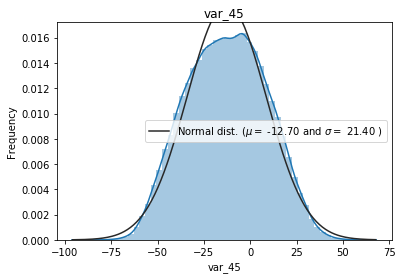

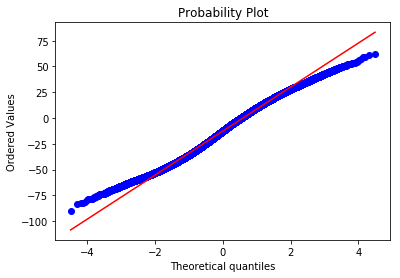


 mu = 5.02 and sigma = 0.01



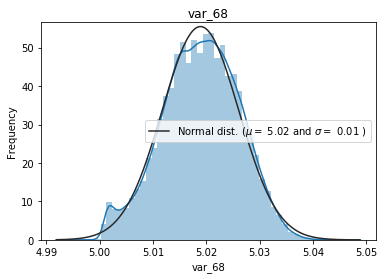

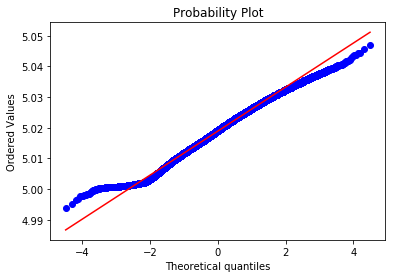

In [7]:
plot_normal_dist(feature = 'var_45')
plot_normal_dist(feature = 'var_68')

Correlation between target and fetaures

In [8]:
corr_with_target = df.corr()["target"].sort_values(ascending=False)

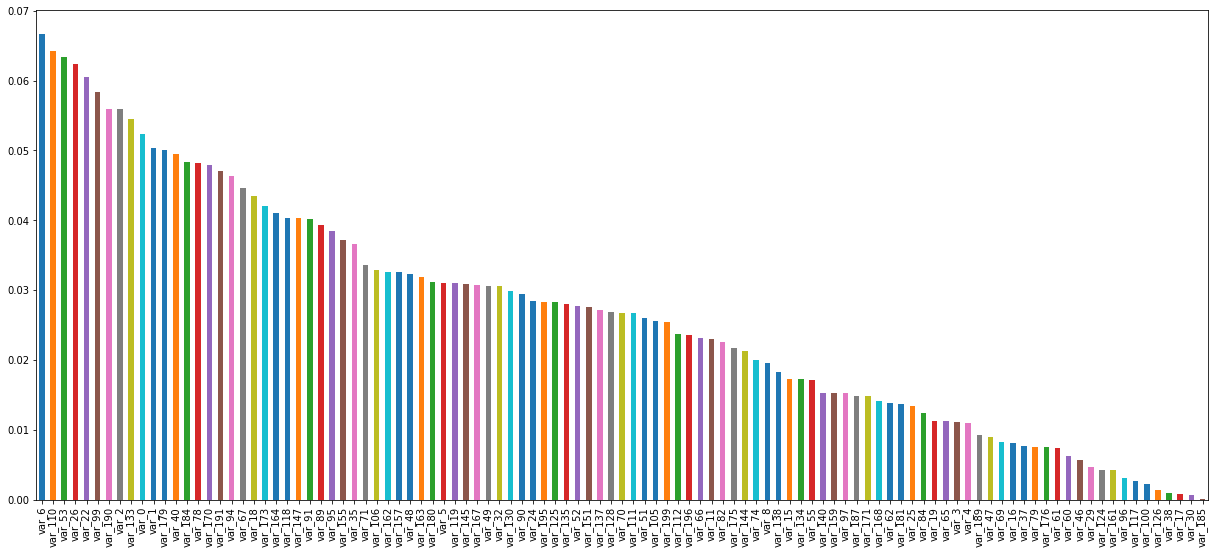

In [9]:
plt.figure(figsize=(21,9))
corr_with_target[1:106].plot.bar()
plt.show();

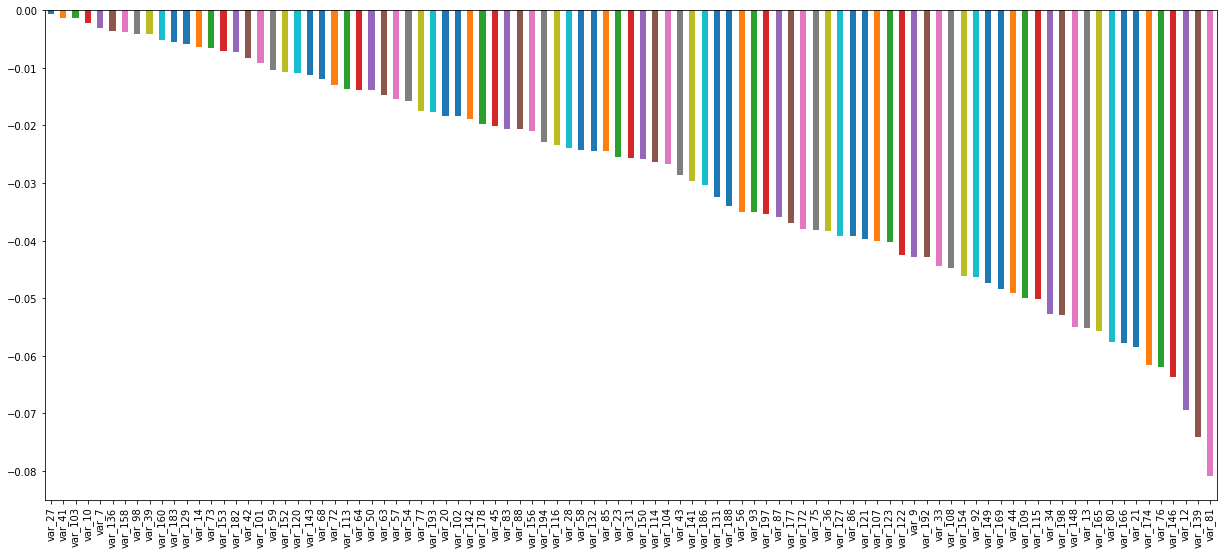

In [10]:
plt.figure(figsize=(21,9))
corr_with_target[106:].plot.bar()
plt.show();

Positive and negative correlations are not significant - all correlations are between 0.07 and -0.08.

Anyway, we present the top 5 postive and negative correlated attributes.

In [11]:
positive_top_5_corr = corr_with_target[1:6]
print(positive_top_5_corr)

negative_top_5_corr = corr_with_target[-5:]
print(negative_top_5_corr)

positive_top_5_corr_index = positive_top_5_corr.index
negative_top_5_corr_index = negative_top_5_corr.index

var_6     0.067
var_110   0.064
var_53    0.063
var_26    0.062
var_22    0.061
Name: target, dtype: float64
var_76    -0.062
var_146   -0.064
var_12    -0.069
var_139   -0.074
var_81    -0.081
Name: target, dtype: float64


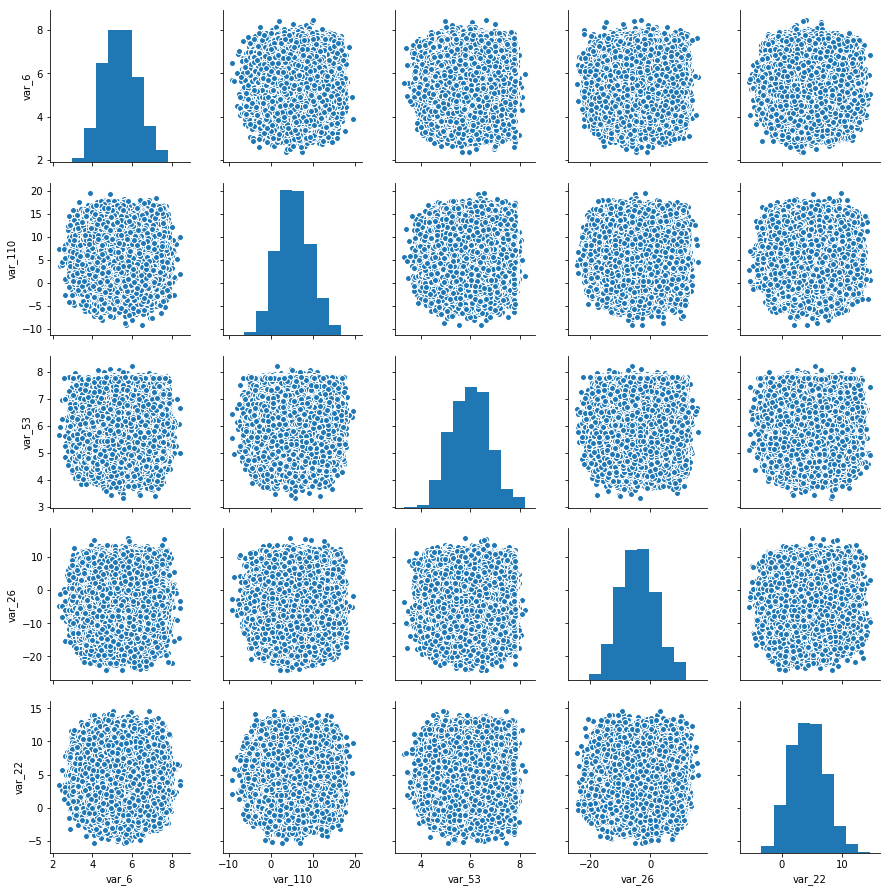

In [12]:
sns.pairplot(df[positive_top_5_corr_index])
plt.show()

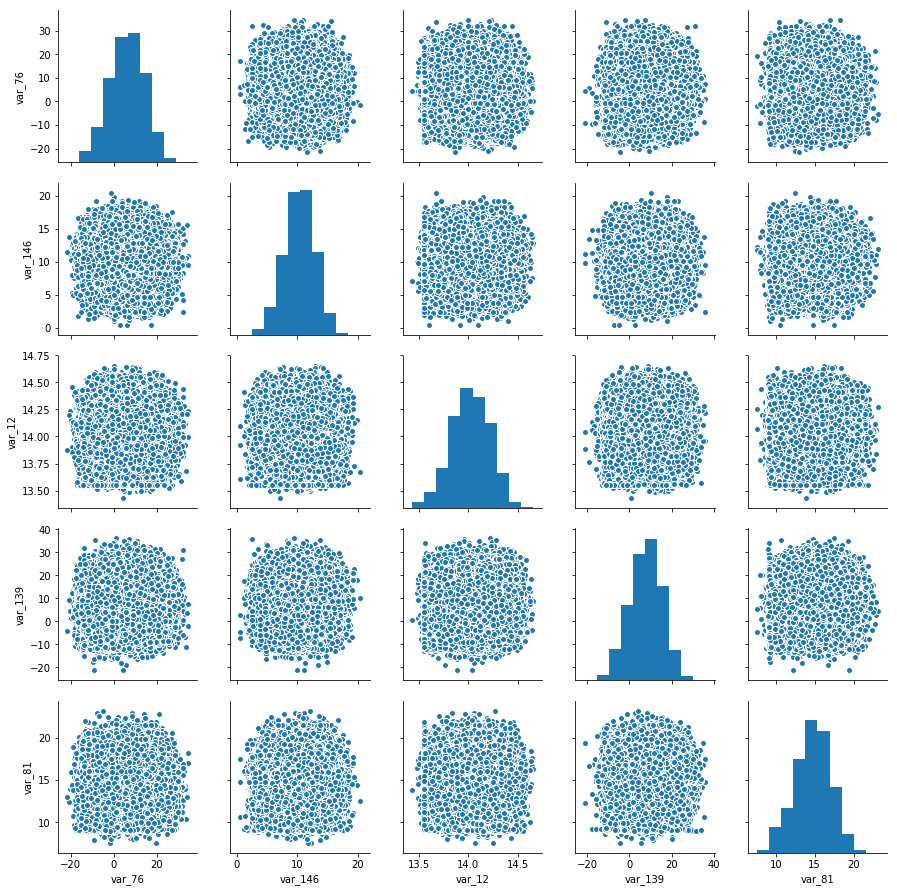

In [13]:
sns.pairplot(df[negative_top_5_corr_index])
plt.show()

Check for skewed features

In [14]:
feature_names = list(df.columns)[2:]
feature_names

skewed_feats = df[feature_names].apply(lambda x: skew(x))

In [15]:
skewed_feats = skewed_feats[skewed_feats > 0.2]
print(skewed_feats)
print(skewed_feats.index)

var_0     0.236
var_2     0.260
var_29    0.200
var_163   0.235
var_168   0.267
var_179   0.243
var_181   0.205
var_191   0.209
dtype: float64
Index(['var_0', 'var_2', 'var_29', 'var_163', 'var_168', 'var_179', 'var_181',
       'var_191'],
      dtype='object')



 mu = 10.68 and sigma = 3.04



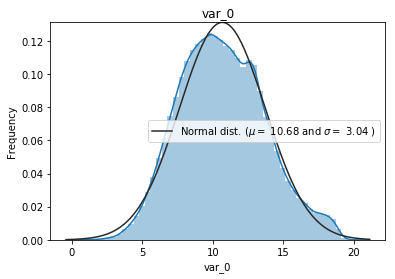

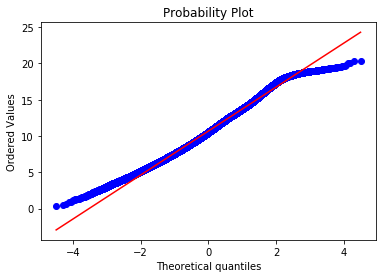

In [16]:
plot_normal_dist(feature = skewed_feats.index[0])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=15)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=15)

x_train = np.float64(x_train)
x_val = np.float64(x_val)
x_test = np.float64(x_test)

ElasticNetCV

In [18]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)
               
cv_model.fit(x_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00000013
Optimal l1_ratio: 0.500
Number of iterations 5


Model Evaluation

In [19]:
y_train_pred = cv_model.predict(x_train)
y_pred = cv_model.predict(x_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  -3.608980682833873
Test r2 score:  0.18576501448223948
Train RMSE: 0.2719
Test RMSE: 0.2722


Feature importance

Index(['var_68', 'var_12', 'var_148', 'var_108', 'var_91'], dtype='object')


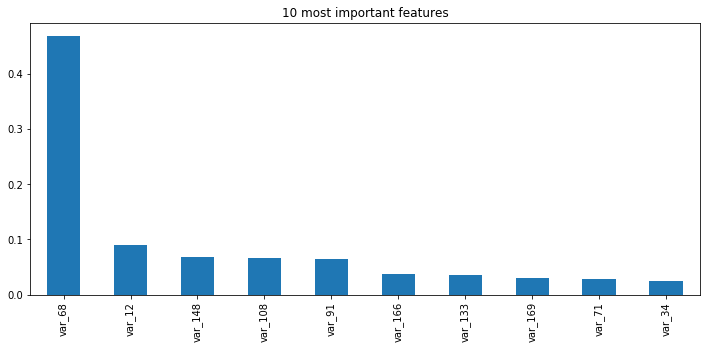

In [20]:
feature_importance = pd.DataFrame(index = feature_names, data = np.abs(cv_model.coef_)).sort_values(by=0, ascending=False)
five_important_features = feature_importance[feature_importance.values > 0.05].index

print(five_important_features)
#feature_importance

#feature_importance.values
feature_importance[:10].plot(kind = 'bar', figsize = (12,5), title="10 most important features", legend=None)
plt.show()

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df[five_important_features], target, test_size=0.2, random_state=15)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=15)

x_train = np.float64(x_train)
x_val = np.float64(x_val)
x_test = np.float64(x_test)

### Xgboost

#### Default model

In [22]:
xgb_model1 = XGBClassifier()
xgb_model1.fit(x_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
y_pre1 = xgb_model1.predict(x_test)
y_pro1 = xgb_model1.predict_proba(x_test)[:, 1]
print("AUC Score :", roc_auc_score(y_test, y_pro1))
print("Accuracy :", accuracy_score(y_test, y_pre1))

AUC Score : 0.6066719261816085
Accuracy : 0.8987


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Default model

In [28]:
%%time
xgb_model2 = XGBClassifier(max_depth=20,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=1000,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)

xgb_model2.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=5, verbose=True)

[0]	validation_0-error:0.123313
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.113625
[2]	validation_0-error:0.111125
[3]	validation_0-error:0.108438
[4]	validation_0-error:0.106188
[5]	validation_0-error:0.10525
[6]	validation_0-error:0.104938
[7]	validation_0-error:0.104687
[8]	validation_0-error:0.104125
[9]	validation_0-error:0.10375
[10]	validation_0-error:0.103437
[11]	validation_0-error:0.103312
[12]	validation_0-error:0.103312
[13]	validation_0-error:0.103437
[14]	validation_0-error:0.102937
[15]	validation_0-error:0.10275
[16]	validation_0-error:0.102688
[17]	validation_0-error:0.102688
[18]	validation_0-error:0.102688
[19]	validation_0-error:0.102812
[20]	validation_0-error:0.102937
[21]	validation_0-error:0.102563
[22]	validation_0-error:0.102625
[23]	validation_0-error:0.102563
[24]	validation_0-error:0.1025
[25]	validation_0-error:0.102563
[26]	validation_0-error:0.102563
[27]	validation_0-error:0.102625
[28]	validation_0-error:0.

In [31]:
%%time

y_pre2 = xgb_model2.predict(x_test)
y_pro2 = xgb_model2.predict_proba(x_test)[:, 1]
print("AUC Score :", roc_auc_score(y_test, y_pro2))
print("Accuracy :", accuracy_score(y_test, y_pre2))

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC Score : 0.568480310764724
Accuracy : 0.89725
Wall time: 2.68 s
